In [2]:
import pandas as pd
import os
import datetime as dt

import requests
import json

In [3]:
#crawl historical trading data from trading view of SSI Iboard API
def data_from_tradingview(symbol):
    #API's URL
    trading_view_data_url = 'https://iboard.ssi.com.vn/dchart/api/history'
    #response template
    data_json = {
        'date': [],
        'open': [],
        'high': [],
        'low': [],
        'close': [],
        'volume': [],
    }

    now = dt.datetime.now()
    current_year = now.year
    
    for year in range(2020, current_year):
        #config duration of data
        begin_date = int(dt.datetime(year, 1, 1).timestamp())
        end_date = int(dt.datetime(year, 12, 31).timestamp())
        #call API
        response = requests.get(
            f'{trading_view_data_url}?symbol={symbol}&resolution=D&from={begin_date}&to={end_date}')
        response_data = json.loads(response.text)
        data_json['date'].extend(response_data['t'])
        data_json['open'].extend(response_data['o'])
        data_json['high'].extend(response_data['h'])
        data_json['low'].extend(response_data['l'])
        data_json['close'].extend(response_data['c'])
        data_json['volume'].extend(response_data['v'])

    #format response data
    df = pd.DataFrame(data_json)
    df = df.astype('float')
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.set_index('date').sort_index()
    return df

# data_from_tradingview('VND')

In [11]:
#config symbol that be visualized
symbol_list = ['VND','SSI']

historical_data_list = []
for symbol in symbol_list:
    stock_historical_data = data_from_tradingview(symbol)
    historical_data_list.append(stock_historical_data)

historical_data_frame = pd.concat(historical_data_list, axis=1, keys=symbol_list)
historical_data_frame.columns.names = ['Bank Name','Stock Info']
historical_data_frame

Bank Name     VND                                    SSI                       \
Stock Info   open   high    low  close     volume   open   high    low  close   
date                                                                            
2020-01-02   3.32   3.41   3.32   3.41    58580.0   8.91   9.05   8.88   9.05   
2020-01-03   3.41   3.41   3.34   3.40   163940.0   9.10   9.15   8.93   8.98   
2020-01-06   3.35   3.40   3.33   3.38   149130.0   8.93   9.01   8.88   8.96   
2020-01-07   3.38   3.38   3.33   3.38    68060.0   8.96   9.01   8.93   8.98   
2020-01-08   3.33   3.34   3.26   3.33   233880.0   8.88   8.91   8.64   8.73   
...           ...    ...    ...    ...        ...    ...    ...    ...    ...   
2021-12-24  31.40  32.16  30.61  31.76  4563800.0  44.45  45.13  43.73  44.31   
2021-12-27  32.24  32.75  31.80  31.80  3352200.0  45.13  45.13  44.27  44.40   
2021-12-28  31.84  32.28  31.20  31.20  5572100.0  44.54  44.76  44.09  44.09   
2021-12-29  31.13  31.92  30.69  31.40  4658000.0  44.18  45.53  43.45  44.85   
2021-12-30  31.76  32.99  31.40  32.91  7017200.0  45.35  47.70  45.26  47.52   

Bank Name               
Stock Info      volume  
date                    
2020-01-02    991450.0  
2020-01-03    703890.0  
2020-01-06   1348120.0  
2020-01-07    643090.0  
2020-01-08   2622960.0  
...                ...  
2021-12-24   8847400.0  
2021-12-27   6529300.0  
2021-12-28   9860100.0  
2021-12-29   9809600.0  
2021-12-30  16605600.0  

[500 rows x 10 columns]

In [12]:
percent_change = pd.DataFrame()
for name in symbol_list:
    percent_change[name] = historical_data_frame[name]['close'].pct_change()
percent_change

,VND,SSI
date,,
2020-01-02,NaN,NaN
2020-01-03,-0.002933,-0.007735
2020-01-06,-0.005882,-0.002227
2020-01-07,0.000000,0.002232
2020-01-08,-0.014793,-0.027840
...,...,...
2021-12-24,0.014049,0.000904
2021-12-27,0.001259,0.002031
2021-12-28,-0.018868,-0.006982


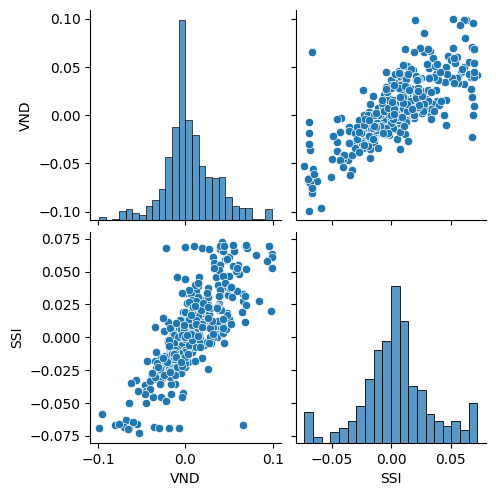

In [13]:
import seaborn as sns
sns.pairplot(percent_change)

<Figure size 1500x500 with 0 Axes>

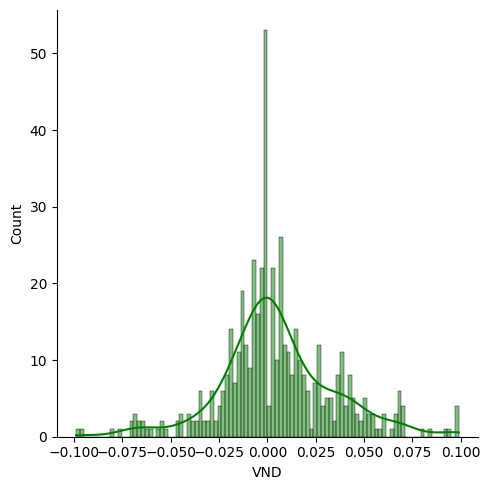

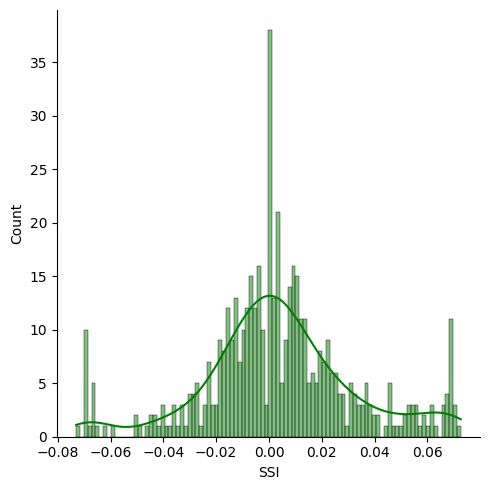

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

# thể hiện percent change của giá chứng khoán bằng phân phối chuẩn(sửa tiếng anh dùm nha)
for stock in percent_change.columns:
    sns.displot(percent_change.loc['2020-01-01':'2021-12-31'][stock],color='green',bins=100, kde=True)

In [17]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
import ta
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True if len(symbol_list) == 1 else False,
                    vertical_spacing=0.03,
                    row_width=[0.2, 0.7])

for stock in symbol_list:
    fig.add_trace(go.Line(
        x=historical_data_frame[stock].index, y=historical_data_frame[stock]['close'], name=stock, line=dict(width=1)))
    if len(symbol_list) == 1:
        # Bar trace for volumes on 2nd row without legend
        fig.add_trace(go.Bar(
            x=historical_data_frame[stock].index, y=historical_data_frame[stock]['volume'], showlegend=False), row=2, col=1)

# Do not show rangeslider plot
fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(
    autosize=False,
    width=780,
    height=540,
)

fig
